# Showcase all the interpolation and derivatives options for pixelated light and mass profiles in `herculens`

__author__: @aymgal

__created on__: 08/08/25

__last update__: 08/08/25

In [1]:
import os
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from matplotlib.colors import Normalize
from scipy.interpolate import RectBivariateSpline
%matplotlib inline
plt.rc('image', interpolation='none')

import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import herculens as hcl
from herculens.Util import plot_util

### Load test image

(100, 100)


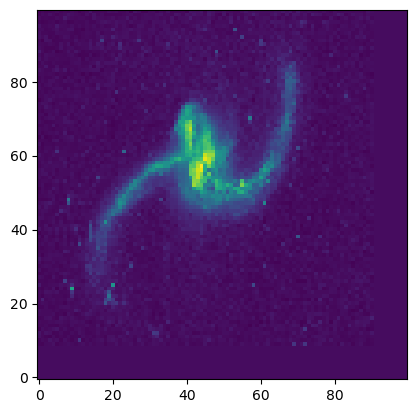

In [2]:
galaxy = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
galaxy_highres = resize(galaxy, (300, 300), anti_aliasing=False)
galaxy_data = resize(galaxy, (100, 100), anti_aliasing=False)
print(galaxy_data.shape)

plt.imshow(galaxy_data, origin='lower')
plt.show()

### Data grid

In [3]:
nx, ny = galaxy_data.shape
pix_scl = 0.08  # arcsec / pixel

# is RA along positive x?
opposite_x_ra = False

# rotation of the frame
rot_angle = 0.  # degrees
rot_angle *= np.pi / 180.  # conversion to radians
rot_matrix = np.array(
    [
        [ np.cos(rot_angle), np.sin(rot_angle)],
        [-np.sin(rot_angle), np.cos(rot_angle)]
    ]
)
transform_pix2angle = np.copy(rot_matrix)
if opposite_x_ra:
    transform_pix2angle[0, 0] *= -1
    transform_pix2angle[0, 1] *= -1
    
transform_pix2angle *= pix_scl

print(transform_pix2angle)

dra, ddec = transform_pix2angle.dot(np.array([int(nx / 2), int(ny / 2)]))
ra_at_xy_0  = - dra
dec_at_xy_0 = - ddec
print(ra_at_xy_0, dec_at_xy_0)

pixel_grid = hcl.PixelGrid(
    nx, ny, transform_pix2angle=transform_pix2angle, 
    ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0
)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords, y_coords = pixel_grid.pixel_axes
extent = pixel_grid.extent

print(f"image size : {pixel_grid.num_pixel_axes} pixels")
print(f"pixel size : {pixel_grid.pixel_width} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

[[ 0.08  0.  ]
 [-0.    0.08]]
-4.0 -4.0
image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (np.float64(-4.0), np.float64(3.92)) arcsec
y range    : (np.float64(-4.0), np.float64(3.92)) arcsec


### Pixelated model grid

In [4]:
model_pixel_grid = pixel_grid.create_model_grid(pixel_scale_factor=2, 
                                                grid_center=None, 
                                                grid_shape=None)

x_grid_model, y_grid_model = model_pixel_grid.pixel_coordinates
x_coords_model, y_coords_model = model_pixel_grid.pixel_axes
model_extent = model_pixel_grid.extent

print(f"image size : {model_pixel_grid.num_pixel_axes} pixels")
print(f"pixel size : {model_pixel_grid.pixel_width} arcsec")
print(f"x range    : {model_extent[0], model_extent[1]} arcsec")
print(f"y range    : {model_extent[2], model_extent[3]} arcsec")

# resize galaxy to match this grid
galaxy_model = resize(galaxy, model_pixel_grid.num_pixel_axes, anti_aliasing=False)

image size : (50, 50) pixels
pixel size : 0.15999999999999998 arcsec
x range    : (np.float64(-3.96), np.float64(3.88)) arcsec
y range    : (np.float64(-3.96), np.float64(3.88)) arcsec


### Image numerics grid

## Interpolators

### `herculens` bilinear

In [5]:
def get_interpolator(
        pixelated_model_type='mass',
        interpolation_type='fast_bilinear', 
        derivative_type='autodiff',
        derivative_order='none',
    ):
    if pixelated_model_type in ['mass', 'light']:
        if pixelated_model_type == 'mass':
            from herculens.MassModel.Profiles.pixelated import PixelatedPotential
            pixelated_class = PixelatedPotential(
                interpolation_type=interpolation_type,
                derivative_type=derivative_type,
            )
            pixelated_class.set_pixel_grid(model_pixel_grid)
        elif pixelated_model_type == 'light':
            from herculens.LightModel.Profiles.pixelated import Pixelated
            pixelated_class = Pixelated(
                interpolation_type=interpolation_type,
                derivative_type=derivative_type,
                adaptive_grid=False,
                allow_extrapolation=False,
            )
            data_pixel_area = 1.
            pixelated_class.set_pixel_grid(model_pixel_grid, data_pixel_area)
        if derivative_order == 'none':
            func = pixelated_class.function
        elif derivative_order == 'dx':
            def func(*args, **kwargs):
                return pixelated_class.derivatives(*args, **kwargs)[0]
        elif derivative_order == 'dy':
            def func(*args, **kwargs):
                return pixelated_class.derivatives(*args, **kwargs)[1]
        elif derivative_order == 'dxx':
            def func(*args, **kwargs):
                dxx, _, _ = pixelated_class.hessian(*args, **kwargs)
                return dxx
        elif derivative_order == 'dyy':
            def func(*args, **kwargs):
                _, dyy, _ = pixelated_class.hessian(*args, **kwargs)
                return dyy
        elif derivative_order == 'dxx+dyy':
            def func(*args, **kwargs):
                dxx, dyy, _ = pixelated_class.hessian(*args, **kwargs)
                return dxx + dyy
        else:
            raise ValueError(f"Derivative order {derivative_order} not yet implemented.")
    elif pixelated_model_type == 'scipy':
        if 'bicubic' in interpolation_type or derivative_order in ['dxx', 'dyy', 'dxx+dyy']:
            spline_degree = 3
        elif 'bilinear' in interpolation_type:
            spline_degree = 2
        else:
            spline_degree = 3
        print(f"Using spline degree {spline_degree} with SciPy's RectBivariateSpline.")
        scipy_interp = lambda pixels: RectBivariateSpline(
            y_coords_model, 
            x_coords_model, 
            pixels,
            kx=spline_degree, ky=spline_degree,
        )
        if derivative_order == 'none':
            def func(x, y, pixels=None):
                return scipy_interp(pixels)(y, x, grid=False)
        elif derivative_order == 'dx':
            def func(x, y, pixels=None):
                return scipy_interp(pixels)(y, x, dy=1, grid=False)
        elif derivative_order == 'dy':
            def func(x, y, pixels=None):
                return scipy_interp(pixels)(y, x, dx=1, grid=False)
        elif derivative_order == 'dxx':
            def func(x, y, pixels=None):
                return scipy_interp(pixels)(y, x, dy=2, grid=False)
        elif derivative_order == 'dyy':
            def func(x, y, pixels=None):
                return scipy_interp(pixels)(y, x, dx=2, grid=False)
        elif derivative_order == 'dxx+dyy':
            def func(x, y, pixels=None):
                dxx = scipy_interp(pixels)(y, x, dy=2, grid=False)
                dyy = scipy_interp(pixels)(y, x, dx=2, grid=False)
                return dxx + dyy
    else:
        raise ValueError(f"Unknown pixelated model type: {pixelated_model_type}")
    return func if pixelated_model_type == 'scipy' else jax.jit(func) 

## Compare runtime of different methods

In [6]:
## Compare runtime of different methods
def estimate_runtime(num_runs=1_000, **settings):
    func = get_interpolator(**settings)

    # run once for compilation
    result = func(x_grid, y_grid, pixels=galaxy_model)
    jax.block_until_ready(result)

    # Now time runtime after compilation/warmup
    start_time = time.perf_counter()
    for _ in range(num_runs):
        result = func(x_grid, y_grid, pixels=galaxy_model)
        jax.block_until_ready(result)
    end_time = time.perf_counter()
    run_time = (end_time - start_time) / num_runs
    
    label = f"{settings['pixelated_model_type']} - {settings['interpolation_type']} - {settings['derivative_type']} - {settings['derivative_order']}"
    print(f"{label} => mean runtime = {run_time:.5f} seconds")

In [7]:
settings_runtime = [
    {
        'pixelated_model_type': 'light',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',  # irrelevant when derivative_order='none'
        'derivative_order': 'none',
    },
    {
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'autodiff',  # irrelevant when derivative_order='none'
        'derivative_order': 'none',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'interpol',
        'derivative_order': 'dx',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dx',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dxx+dyy',
    },
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dxx+dyy',
    },

    # NOTE: add the one you want :)
]

for settings in settings_runtime:
    try:
        estimate_runtime(
            **settings,
        )
    except Exception as e:
        label = f"{settings['pixelated_model_type']} - {settings['interpolation_type']} - {settings['derivative_type']} - {settings['derivative_order']}"
        print(f"Skipping {label} due to error: {e}")
    print("-" * 80)

light - fast_bilinear - autodiff - none => mean runtime = 0.00008 seconds
--------------------------------------------------------------------------------
light - bilinear - autodiff - none => mean runtime = 0.00043 seconds
--------------------------------------------------------------------------------
mass - fast_bilinear - autodiff - dx => mean runtime = 0.00016 seconds
--------------------------------------------------------------------------------
mass - fast_bilinear - interpol - dx => mean runtime = 0.00042 seconds
--------------------------------------------------------------------------------
mass - bicubic - autodiff - dx => mean runtime = 0.00092 seconds
--------------------------------------------------------------------------------
mass - bicubic - interpol - dx => mean runtime = 0.00104 seconds
--------------------------------------------------------------------------------
mass - bicubic - autodiff - dxx+dyy => mean runtime = 0.00654 seconds
-----------------------------

## Compare the interpolated images

In [8]:
def compare_images(settings_1, settings_2=None, vdiff=None):
    if settings_1['pixelated_model_type'] == 'scipy':
        title_1 = f"{settings_1['pixelated_model_type']} - {settings_1['derivative_order']}"
    else:
        title_1 = f"{settings_1['pixelated_model_type']} - {settings_1['interpolation_type']} - {settings_1['derivative_type']} - {settings_1['derivative_order']}"
    func1 = get_interpolator(**settings_1)
    result1 = func1(x_grid, y_grid, pixels=galaxy_model)
    print("min/max for result1:", result1.min(), result1.max())
    if settings_2 is not None:
        if settings_2['pixelated_model_type'] == 'scipy':
            title_2 = f"{settings_2['pixelated_model_type']} - {settings_2['derivative_order']}"
        else:
            title_2 = f"{settings_2['pixelated_model_type']} - {settings_2['interpolation_type']} - {settings_2['derivative_type']} - {settings_2['derivative_order']}"
        func2 = get_interpolator(**settings_2)
        result2 = func2(x_grid, y_grid, pixels=galaxy_model)
        print("min/max for result2:", result2.min(), result2.max())
    
    # 3 subplots figure showing the results
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    im1 = axs[0].imshow(result1, origin='lower', cmap='viridis')
    plot_util.nice_colorbar(im1)
    axs[0].set_title(title_1)
    if settings_2 is not None:
        im2 = axs[1].imshow(result2, origin='lower', cmap='viridis')
        plot_util.nice_colorbar(im2)
        axs[1].set_title(title_2)
        if vdiff is not None:
            rel_diff = (result1 - result2) / result1
            vmin, vmax = -vdiff, vdiff
            im3 = axs[2].imshow(rel_diff, origin='lower', cmap='bwr', norm=Normalize(vmin, vmax))
            plot_util.nice_colorbar_residuals(im3, rel_diff, vmin, vmax)
            axs[2].set_title("Relative difference")
        else:
            axs[2].axis('off')
    else:
        axs[1].axis('off')
        axs[2].axis('off')
    plt.tight_layout()
    plt.show()

min/max for result1: -0.025473714632077153 0.8097024250036559
min/max for result2: -0.025473714632067046 0.8097024250037239


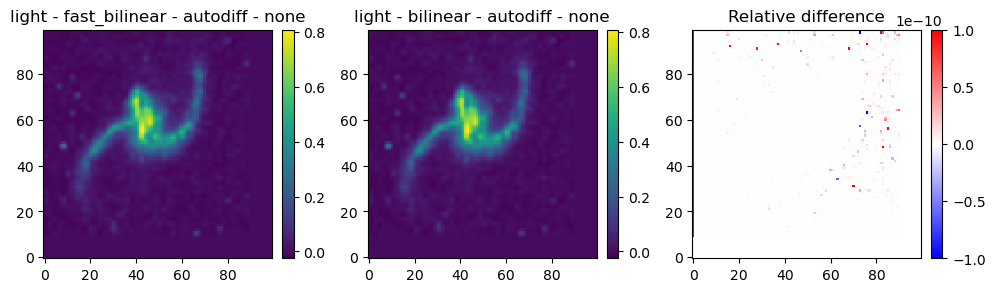

In [9]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    vdiff=1e-10
)

min/max for result1: -0.025473714632067046 0.8097024250037239
min/max for result2: -0.037491045041437535 0.8714237713579027


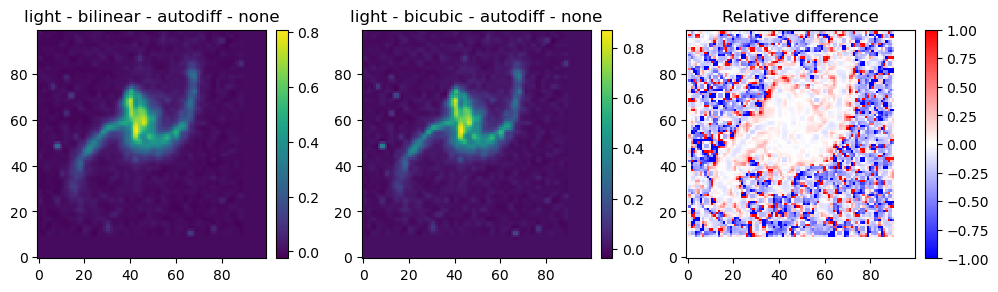

In [10]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    vdiff=1.
)

min/max for result1: -2.9858913262067466 3.0632167353459168
min/max for result2: -2.9858913262067444 3.0632167353459145


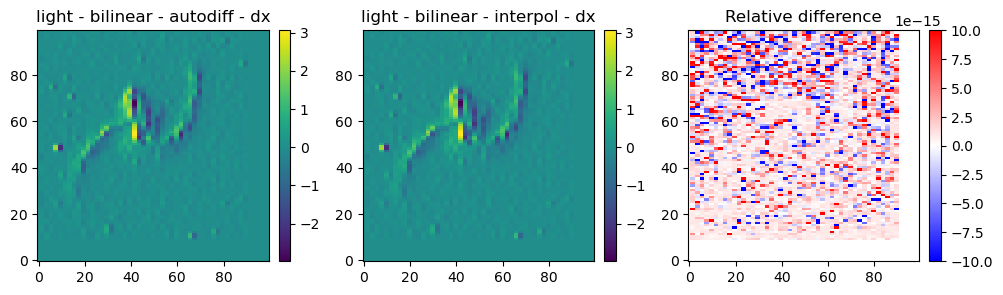

In [11]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    vdiff=1e-14
)

min/max for result1: -3.6098342875774896 3.688609701752372
min/max for result2: -3.6098342875774865 3.6886097017523687


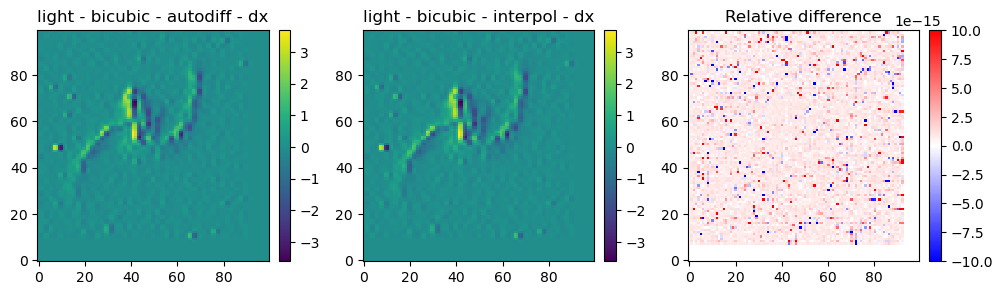

In [12]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    vdiff=1e-14
)

min/max for result1: -2.9858913262067444 3.0632167353459145
min/max for result2: -3.6098342875774865 3.6886097017523687


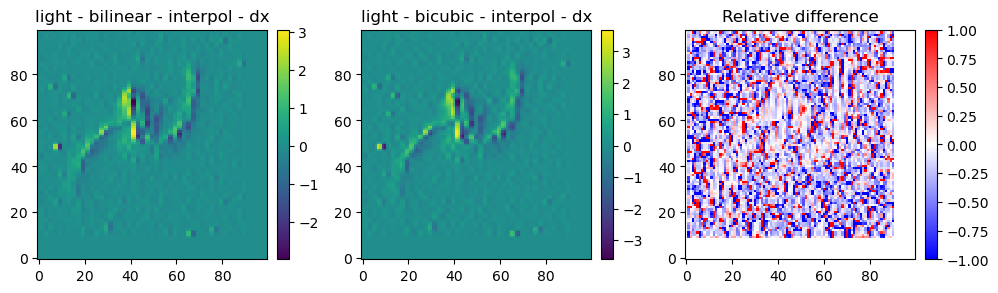

In [13]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bilinear',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    vdiff=1
)

min/max for result1: -2.9858913262067537 3.0632167353459065
min/max for result2: -2.1938839461089867 2.0831620869089242


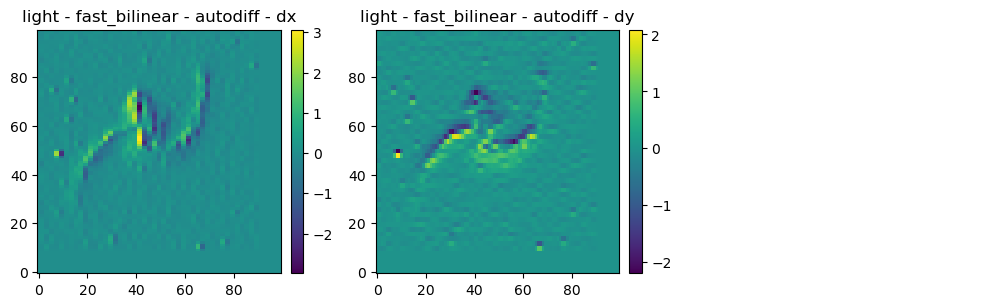

In [14]:
compare_images(
    settings_1={
        'pixelated_model_type': 'light',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'light',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dy'
    },
    vdiff=None
)

min/max for result1: -0.025473714632077153 0.8097024250036559
min/max for result2: -0.037491045041437535 0.8714237713579027


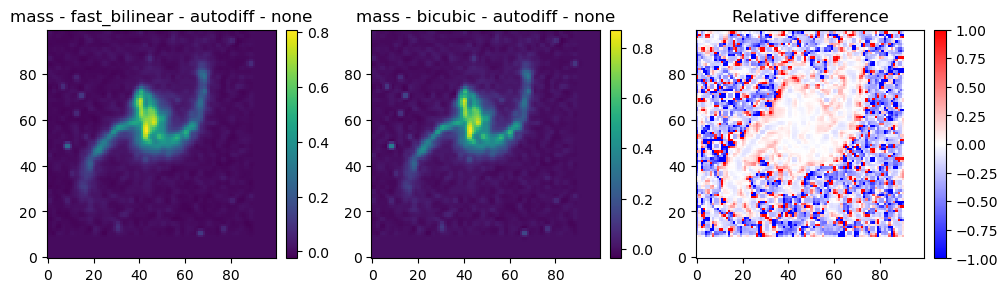

In [15]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    vdiff=1.
)

min/max for result1: -0.025473714632077153 0.8097024250036559
Using spline degree 2 with SciPy's RectBivariateSpline.
min/max for result2: -0.05020570092065179 0.8860088451352089


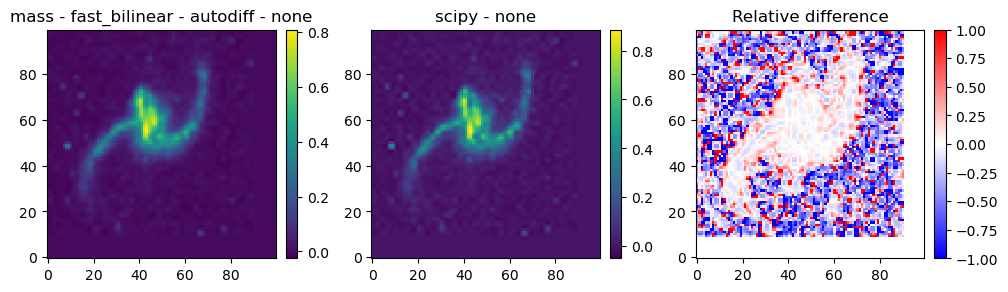

In [16]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    settings_2={
        'pixelated_model_type': 'scipy',
        'derivative_order': 'none'
    },
    vdiff=1.
)

min/max for result1: -2.9858913262067537 3.0632167353459065
min/max for result2: -2.1938839461089867 2.0831620869089242


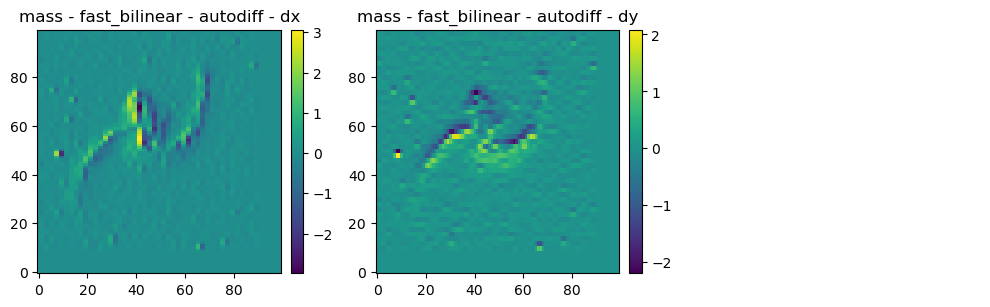

In [17]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dy'
    },
)

min/max for result1: -2.9858913262067537 3.0632167353459065
min/max for result2: -3.6098342875774896 3.688609701752372


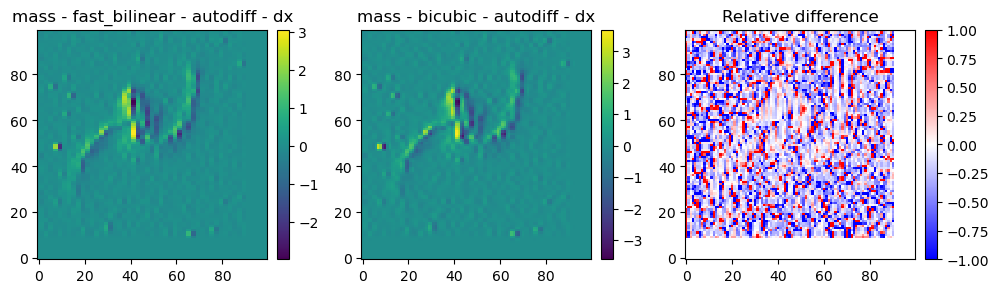

In [18]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    vdiff=1,
)

min/max for result1: -2.9858913262067537 3.0632167353459065
min/max for result2: -2.9858913262067444 3.0632167353459145


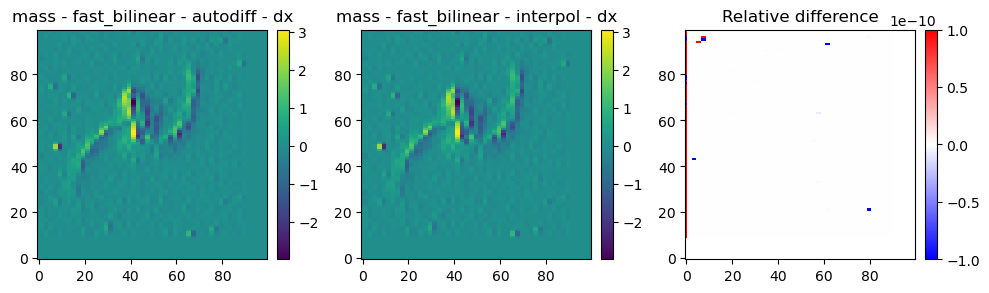

In [19]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'fast_bilinear',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    vdiff=1e-10,
)

min/max for result1: -3.6098342875774896 3.688609701752372
min/max for result2: -3.6098342875774865 3.6886097017523687


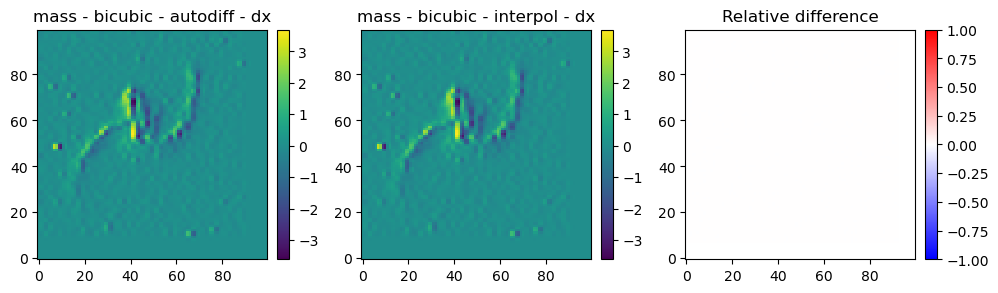

In [20]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    vdiff=1,
)

min/max for result1: -3.6098342875774896 3.688609701752372
Using spline degree 2 with SciPy's RectBivariateSpline.
min/max for result2: -3.3987382383082676 3.542004410181717


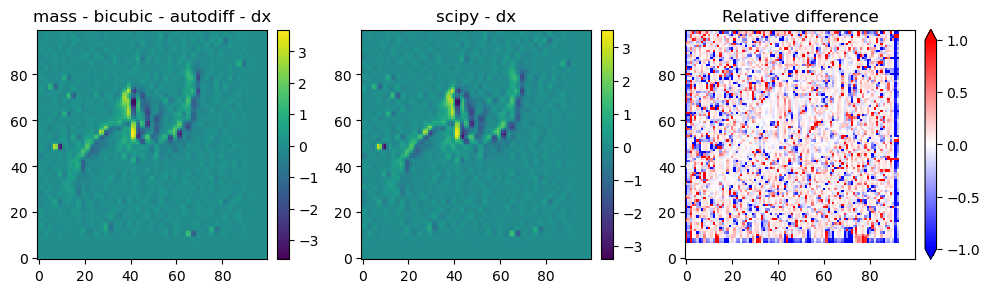

In [21]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'scipy',
        'derivative_order': 'dx'
    },
    vdiff=1
)

min/max for result1: -3.6098342875774865 3.6886097017523687
Using spline degree 2 with SciPy's RectBivariateSpline.
min/max for result2: -3.3987382383082676 3.542004410181717


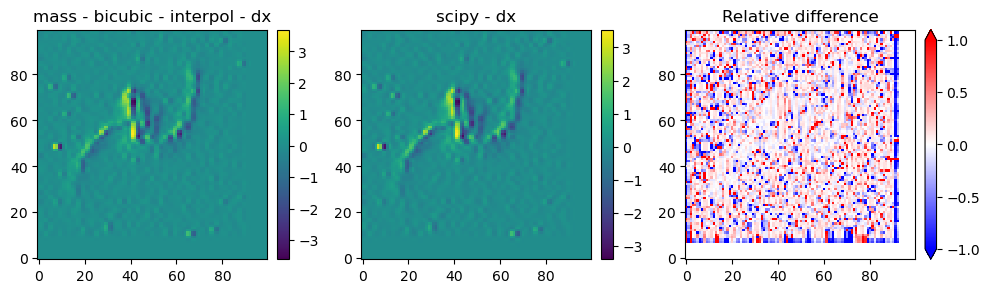

In [22]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dx'
    },
    settings_2={
        'pixelated_model_type': 'scipy',
        'derivative_order': 'dx'
    },
    vdiff=1
)

min/max for result1: -46.01065997021826 39.23224136745967
min/max for result2: -46.01065997021835 39.23224136745974


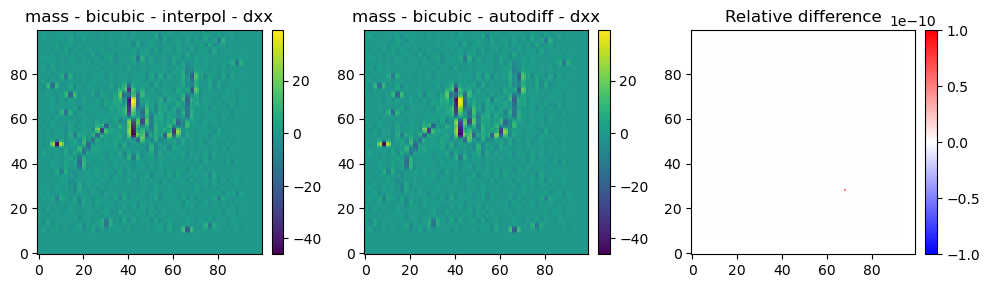

In [23]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dxx'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dxx'
    },
    vdiff=1e-10
)

min/max for result1: -85.04335532293119 47.0162112829346
min/max for result2: -85.04335532293135 47.016211282934684


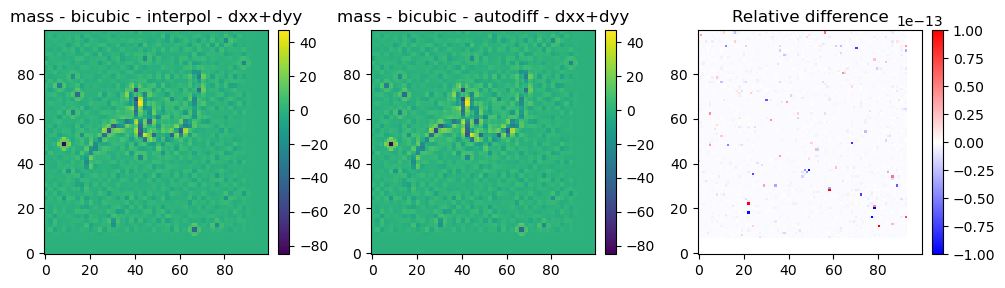

In [24]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dxx+dyy'
    },
    settings_2={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dxx+dyy'
    },
    vdiff=1e-13
)

min/max for result1: -85.04335532293135 47.016211282934684
Using spline degree 3 with SciPy's RectBivariateSpline.
min/max for result2: -82.94155176698828 53.54546426277645


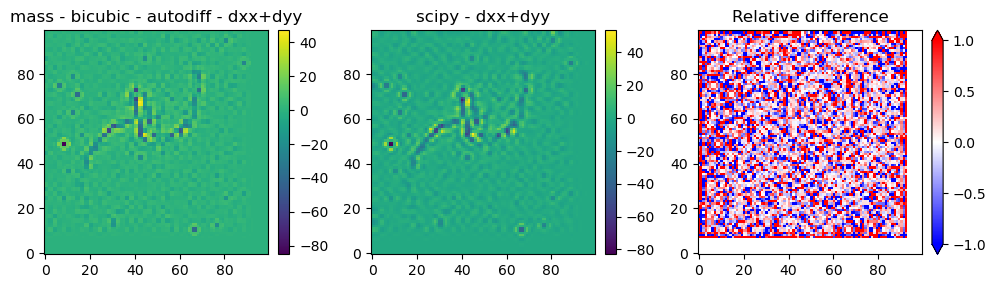

In [25]:
compare_images(
    settings_1={
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dxx+dyy'
    },
    settings_2={
        'pixelated_model_type': 'scipy',
        'derivative_order': 'dxx+dyy'
    },
    vdiff=1
)

## Test the derivatives with respect to an analytical mass profile

Because there is a normalization mismatch between the "analytical" derivates from `utax` interpolators, and the ones from SciPy or found using jax.grad.

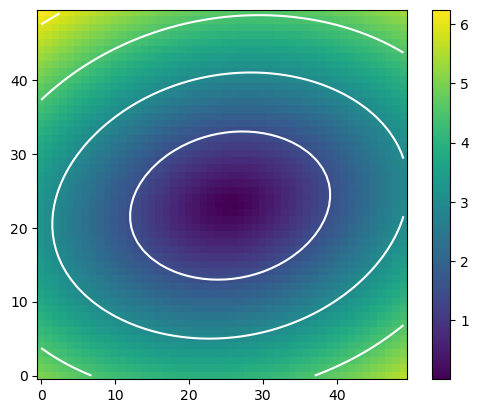

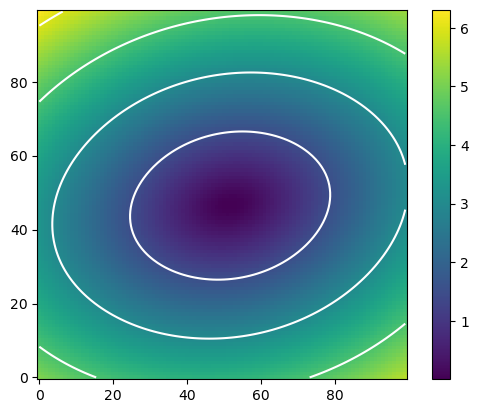

In [26]:
# we first pick some mass distribution for which we have the potential and derivates
analytical_mass = hcl.MassModel(hcl.PIEMD())
kwargs_mass = [{'theta_E': 1.1, 'r_core': 0.2, 'q': 0.4, 'phi': 0.21, 'center_x': 0.13, 'center_y':-0.28}]
analytical_model = analytical_mass.potential(x_grid_model, y_grid_model, kwargs_mass)
analytical_truth = analytical_mass.potential(x_grid, y_grid, kwargs_mass)
analytical_truth_dx, analytical_truth_dy = analytical_mass.alpha(x_grid, y_grid, kwargs_mass)
analytical_truth_dxxdyy = 2 * analytical_mass.kappa(x_grid, y_grid, kwargs_mass)

plt.imshow(analytical_model)
plt.colorbar()
plt.contour(analytical_model, levels=5, colors='white')
plt.show()
plt.imshow(analytical_truth)
plt.colorbar()
plt.contour(analytical_truth, levels=5, colors='white')
plt.show()

In [27]:
def compare_with_analytical_profile(
    settings,
    vdiff=None,
):
    title_1 = f"{settings['pixelated_model_type']} - {settings['interpolation_type']} - {settings['derivative_type']} - {settings['derivative_order']}"
    func1 = get_interpolator(**settings)
    result1 = func1(x_grid, y_grid, pixels=analytical_model)
    print("min/max for result1:", result1.min(), result1.max())
    
    if settings['derivative_order'] == 'none':
        result2 = analytical_truth
    elif settings['derivative_order'] == 'dx':
        result2 = analytical_truth_dx
    elif settings['derivative_order'] == 'dy':
        result2 = analytical_truth_dy
    elif settings['derivative_order'] == 'dxx+dyy':
        result2 = analytical_truth_dxxdyy
    else:
        raise ValueError(f"derivative_order '{settings['derivative_order']}' not implemented")

    print("min/max for result2:", result2.min(), result2.max())
    
    # 3 subplots figure showing the results
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    im1 = axs[0].imshow(result1, origin='lower', cmap='viridis')
    plot_util.nice_colorbar(im1)
    axs[0].set_title(title_1)
    im2 = axs[1].imshow(result2, origin='lower', cmap='viridis')
    plot_util.nice_colorbar(im2)
    axs[1].set_title("Analytical reference")
    if vdiff is not None:
        rel_diff = (result1 - result2) / result1
        vmin, vmax = -vdiff, vdiff
        im3 = axs[2].imshow(rel_diff, origin='lower', cmap='bwr', norm=Normalize(vmin, vmax))
        plot_util.nice_colorbar_residuals(im3, rel_diff, vmin, vmax)
        axs[2].set_title("Relative difference")
    else:
        axs[2].axis('off')
    plt.tight_layout()
    plt.show()

min/max for result1: 0.004803327065632225 6.22787220137266
min/max for result2: 0.0038387493259291463 6.30963255073287


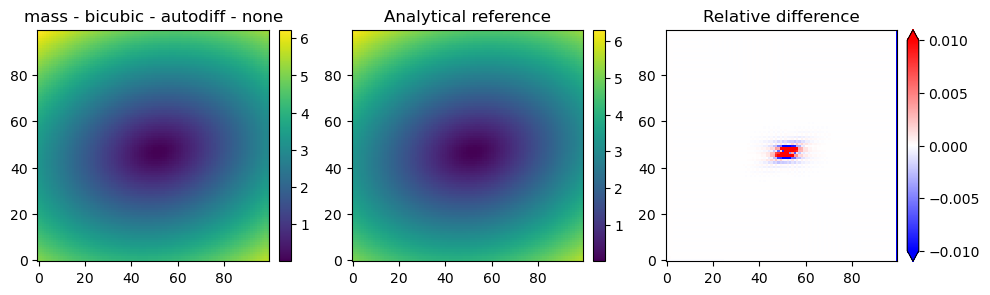

In [28]:
compare_with_analytical_profile(
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'none'
    },
    vdiff=1e-2,
)

min/max for result1: -0.9198677442483425 0.9151338637658728
min/max for result2: -0.9210436716264877 0.9165270603976139


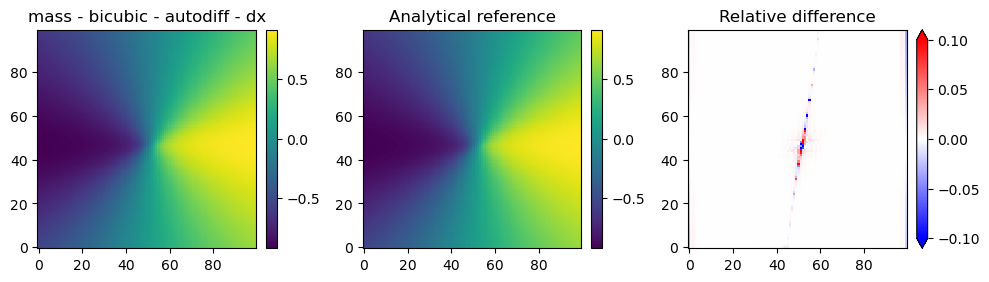

In [29]:
compare_with_analytical_profile(
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dx'
    },
    vdiff=1e-1,
)

min/max for result1: -1.2186936829382438 1.2251490351258592
min/max for result2: -1.220090556175493 1.2262519458429921


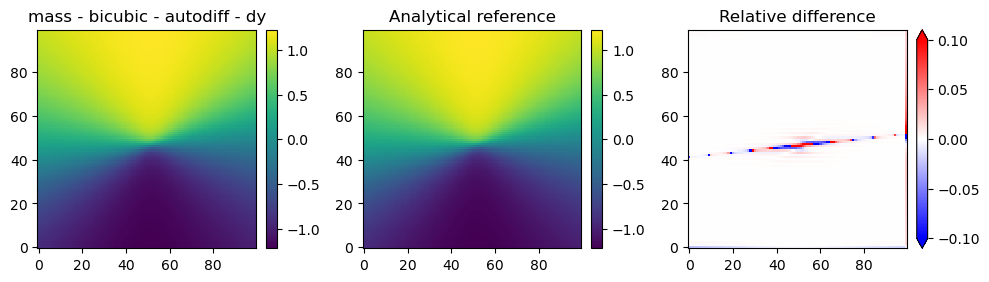

In [30]:
compare_with_analytical_profile(
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dy'
    },
    vdiff=1e-1,
)

min/max for result1: -0.4213529479585393 6.146363929605638
min/max for result2: 0.14685624853123386 6.28319555196563


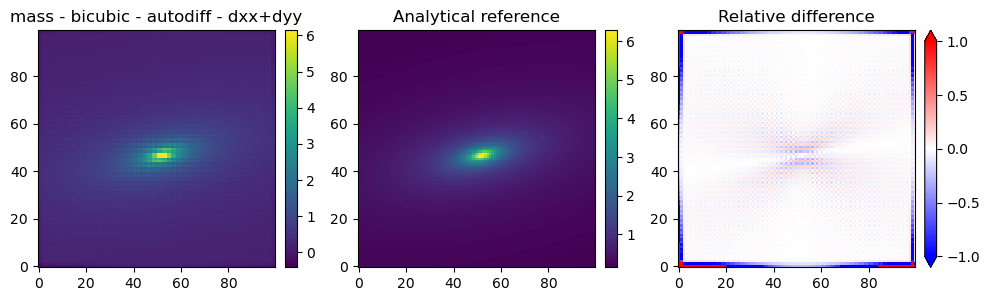

In [31]:
compare_with_analytical_profile(
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'autodiff',
        'derivative_order': 'dxx+dyy'
    },
    vdiff=1,
)

min/max for result1: -0.42135294795853845 6.146363929605626
min/max for result2: 0.14685624853123386 6.28319555196563


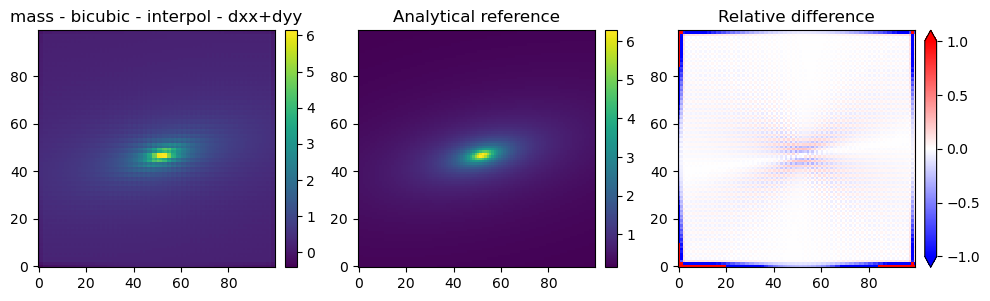

In [32]:
compare_with_analytical_profile(
    {
        'pixelated_model_type': 'mass',
        'interpolation_type': 'bicubic',
        'derivative_type': 'interpol',
        'derivative_order': 'dxx+dyy'
    },
    vdiff=1,
)